## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import sys
import os

sys.path.append(os.path.abspath(".."))
from src.utils import *

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
#import kmeans 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pickle as pkl
pd.set_option('display.max_columns', None)

## Explore Data

In [2]:
config = read_config()
segmentation_path = os.path.join(os.getcwd(),"..","Data" ,config["filenames"]["segmentation"])
df = pd.read_csv(segmentation_path, index_col=0)
df.head()


c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\src\..


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


- We don't need ID for modelling
- Age and Income should be scaled to ignore the bias 
- Occupation, Education and Settlement size are Ordinal categorical variables
- Marital Status and Sex are Binary categorical variables.

In [3]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [4]:
df.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

### Plotting

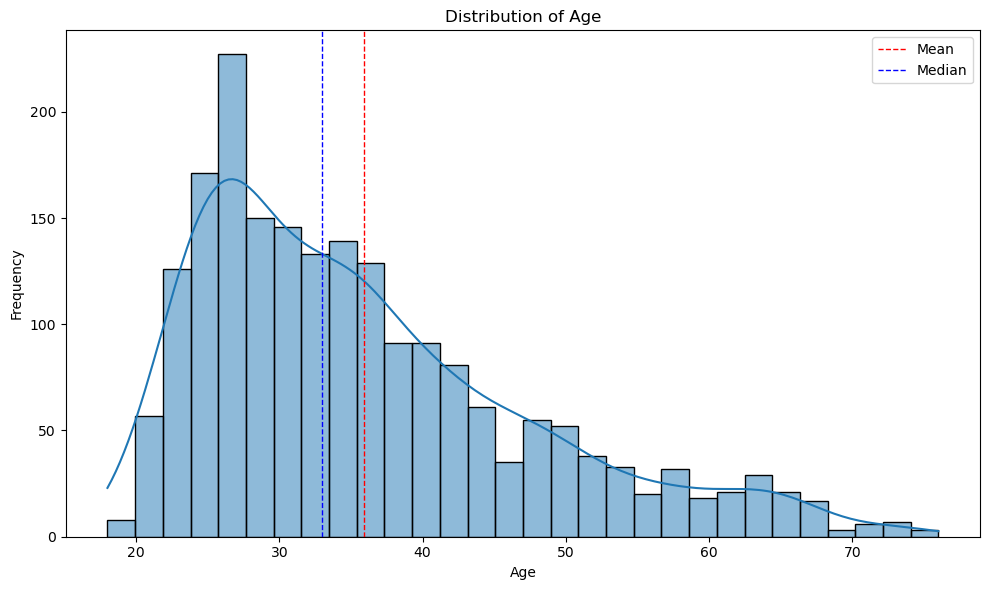

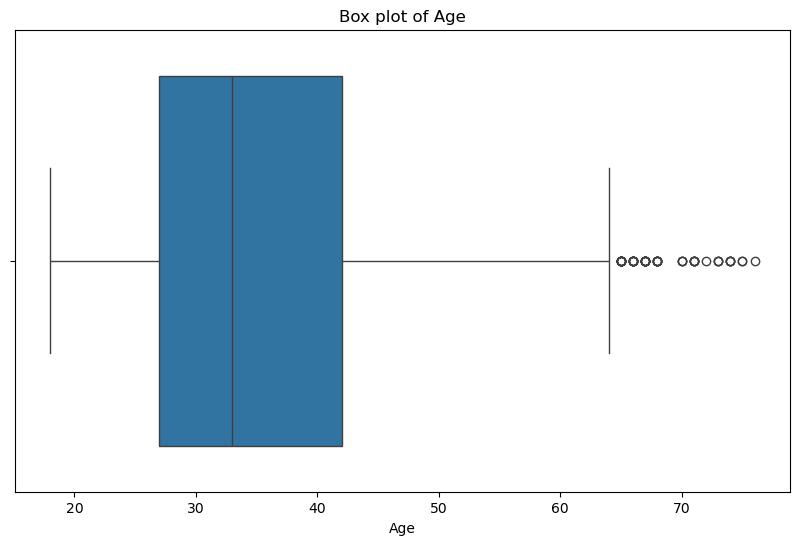

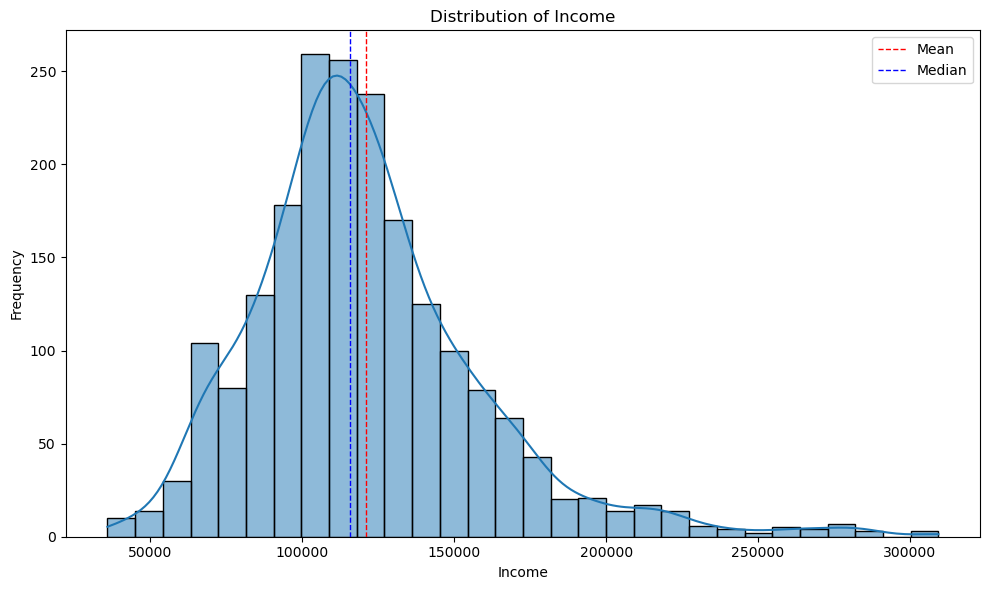

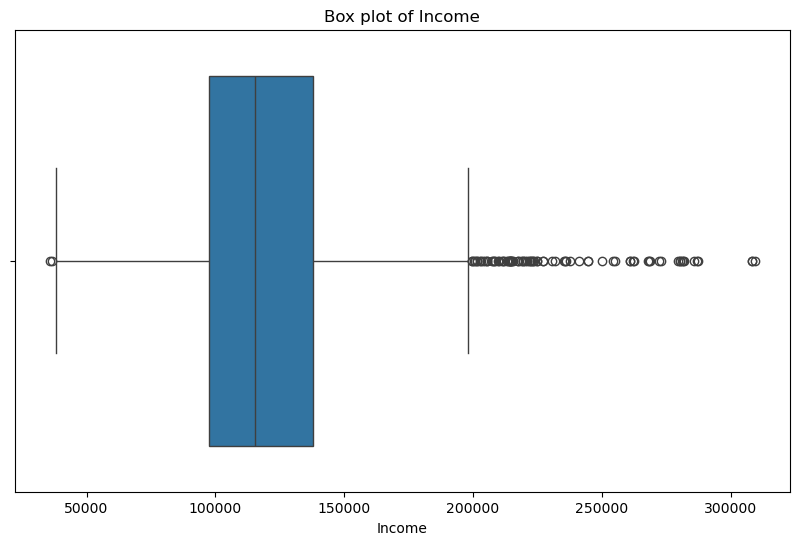

In [5]:
univariate_cols = ["Age","Income"]
for col in univariate_cols:
    plot_distribution(df, col, title=f"Distribution of {col}")
    box_plot(df, col, title=f"Box plot of {col}")


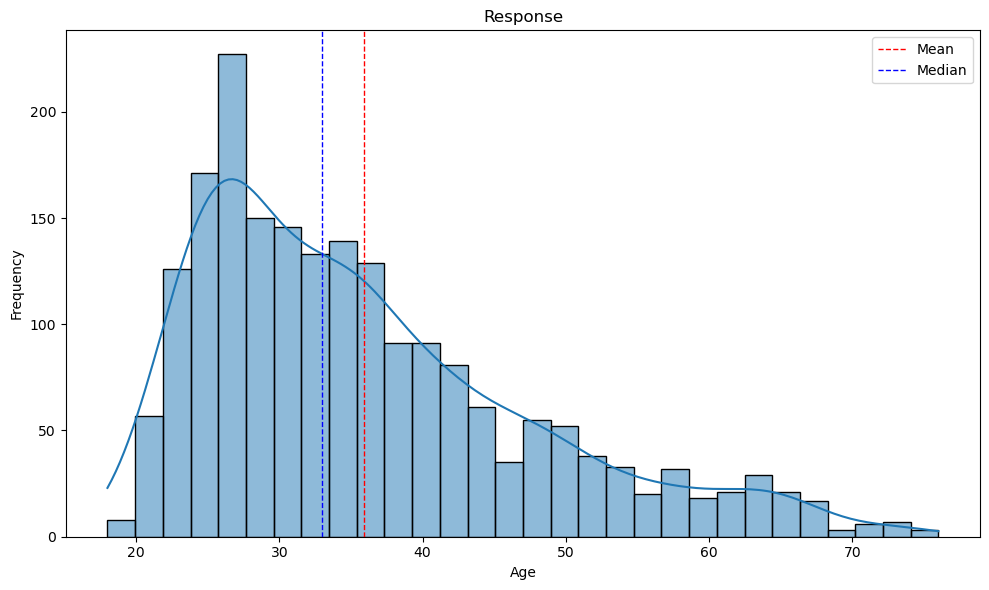

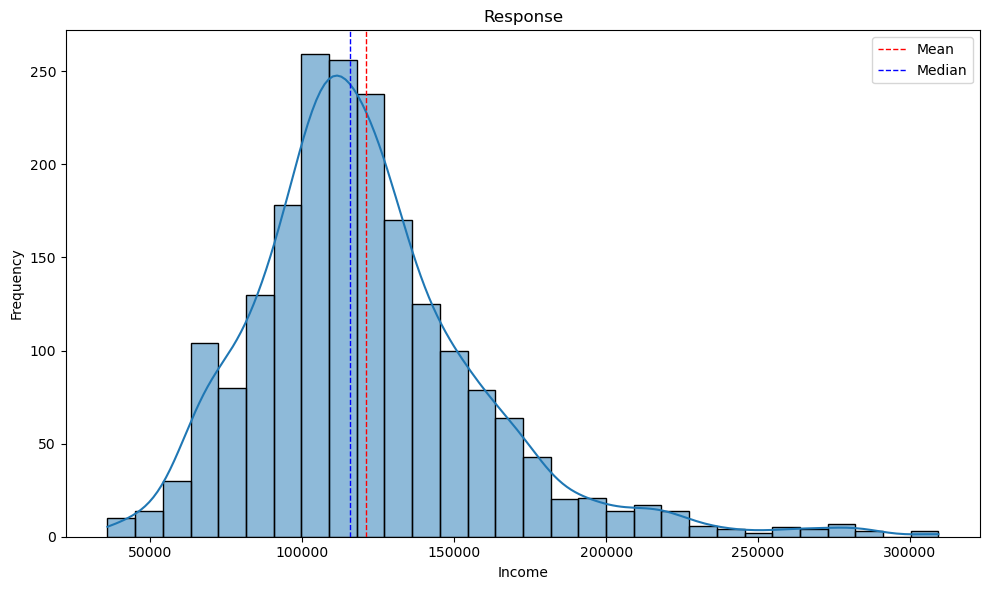

In [6]:
plot_distribution(df, "Age", "Response")
plot_distribution(df, "Income", "Response")

- Age is right skewed which means the dataset has a lot of young customers.
- Income is almost normal except some slight skewness towards right.
- Mean and Median of income is pretty close.

c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\src\utils.py:139: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_column, y=y_column,hue= hue, palette='viridis')


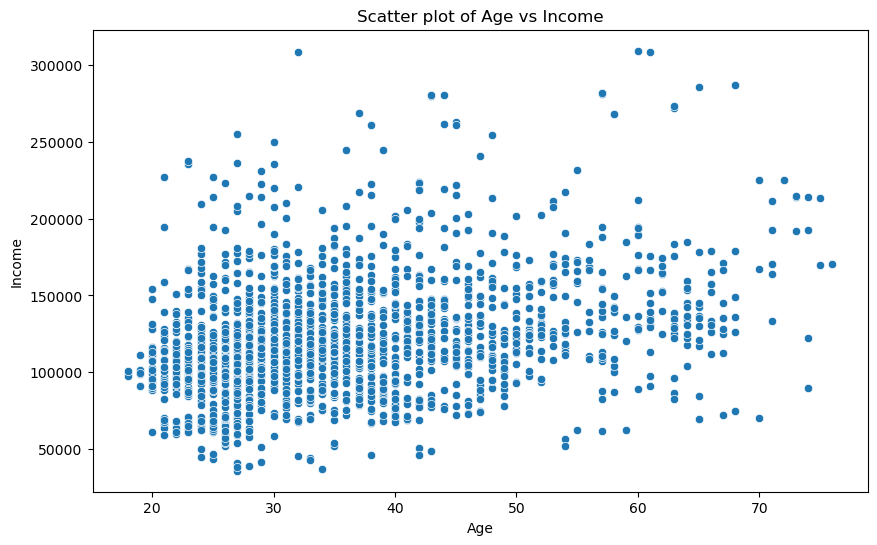

In [7]:
scatter_plot_pairs = [("Age", "Income")]

for x, y in scatter_plot_pairs:
    scatter_plot(df, x, y, title=f"Scatter plot of {x} vs {y}")

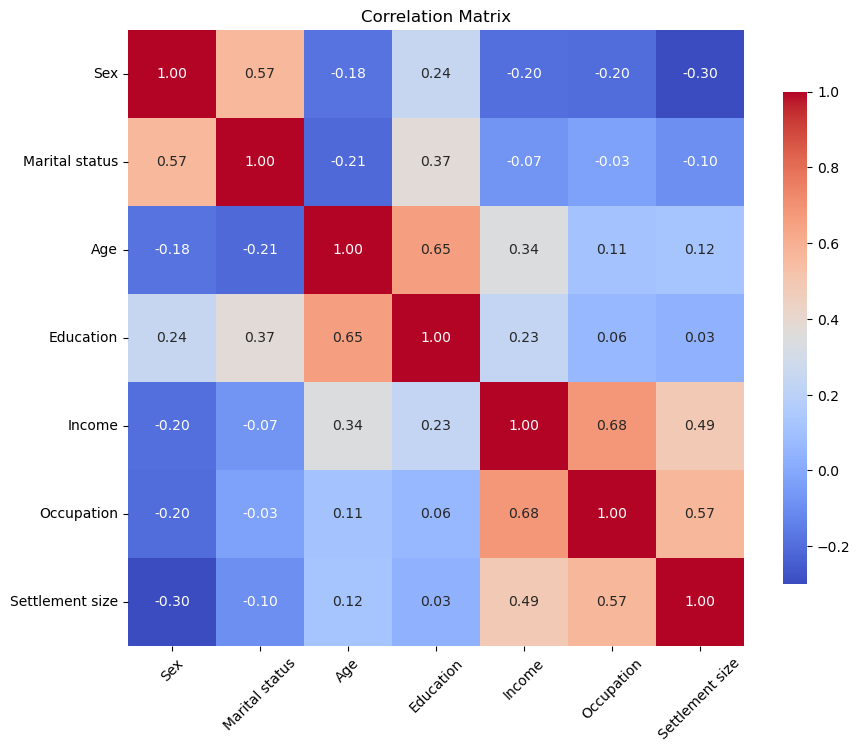

In [8]:
plot_correlation_matrix(df, title="Correlation Matrix")

- High correlation between Age and Education, Occupation and Income

## Standardization of Age and Income

In [9]:
scaler = StandardScaler()
cols_to_scale = ["Age", "Income"]
columns = df.columns.tolist()
# but we will scale all columns for consistency
data = scaler.fit_transform(df)


## Hierarchical Clustering

## Ward’s Linkage:
Ward’s linkage merges clusters to minimize the increase in total within-cluster variance (or error sum of squares).

In other words, at each step, it chooses the merge that causes the smallest increase in variance of the combined cluster.

This method focuses on keeping clusters as compact and homogeneous as possible.

In [10]:
clusters = linkage(data, method='ward')


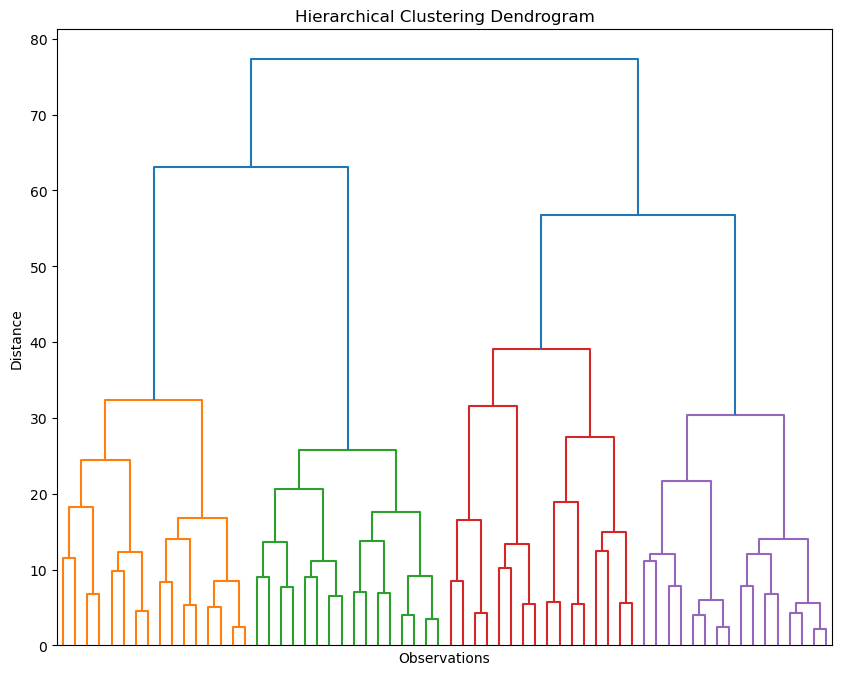

In [11]:
plot_dendrogram(clusters, levels=5)

Longest vertical line which is not intercepted by the horizontal line.

We can start with the Hierarchical clustering to decide upon the number of clusters.

In [12]:
number_of_clusters = clusters.shape[-1]
print(f"Number of clusters from hierarchical clustering: {number_of_clusters}")

Number of clusters from hierarchical clustering: 4


## K means Clustering

- Initialize with best possible centroids.
- try to identify the best cluster count using the elbow method by inspecing the plot of wcss.

In [13]:
wcss = []

for i in range(1,11,1):
    kmeans = KMeans(n_clusters=i,init="k-means++", random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    # inertia is the sum of squared distances of samples to their closest cluster center



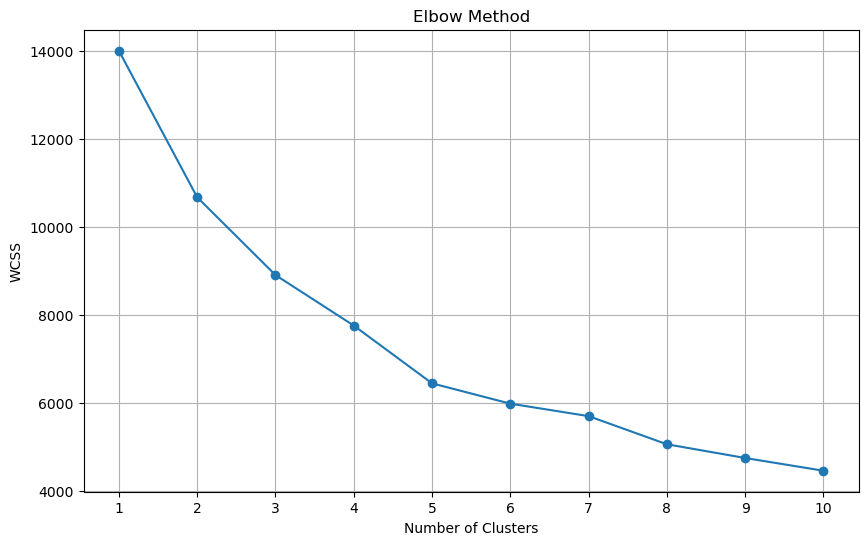

In [14]:
plot_elbow(wcss = wcss)

In [15]:
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42)
kmeans.fit(data)

KMeans(n_clusters=5, random_state=42)

In [16]:
df_segmented = df.copy()
df_segmented["Cluster"] = kmeans.labels_

segment_analysis = df_segmented.groupby("Cluster").mean()
segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Cluster,,,,,,,
0,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063
1,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000
2,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745
3,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446
4,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000


In [17]:
segment_analysis['k_obs'] = df_segmented.groupby(["Cluster"])['Sex'].count()
segment_analysis['prop_obs'] = segment_analysis["k_obs"]/segment_analysis["k_obs"].sum()
segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,k_obs,prop_obs
Cluster,,,,,,,,,
0,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063,318,0.1590
1,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000,434,0.2170
2,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745,529,0.2645
3,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446,469,0.2345
4,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000,250,0.1250


- Cluster 0 : Men who are unmarried stands out
- Cluster 1 : Women who are married but unemployed
- Cluster 2 : Standard 
- Cluster 3 : Does well in Occupation and Income
- Cluster 4 : Education and income are above par

In [18]:
cluster_renaming = {
    0 : "Unmarried Men",
    1 : "Typical Women",
    2 : "Standard",
    3 : "Career Focussed",
    4 : "Well off"
}
segment_analysis = segment_analysis.reset_index()
segment_analysis['Cluster_Description'] = segment_analysis['Cluster'].map(cluster_renaming)
segment_analysis

,Cluster,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,k_obs,prop_obs,Cluster_Description
0,0,0.028302,0.000000,35.418239,0.619497,100066.210692,0.393082,0.110063,318,0.1590,Unmarried Men
1,1,0.891705,0.652074,33.297235,1.108295,89360.076037,0.094470,0.000000,434,0.2170,Typical Women
2,2,0.748582,0.979206,27.924386,1.003781,119900.778828,1.052930,0.814745,529,0.2645,Standard
3,3,0.004264,0.044776,37.142857,0.710021,144048.624733,1.283582,1.539446,469,0.2345,Career Focussed
4,4,0.480000,0.684000,55.648000,2.136000,161276.772000,1.184000,1.160000,250,0.1250,Well off


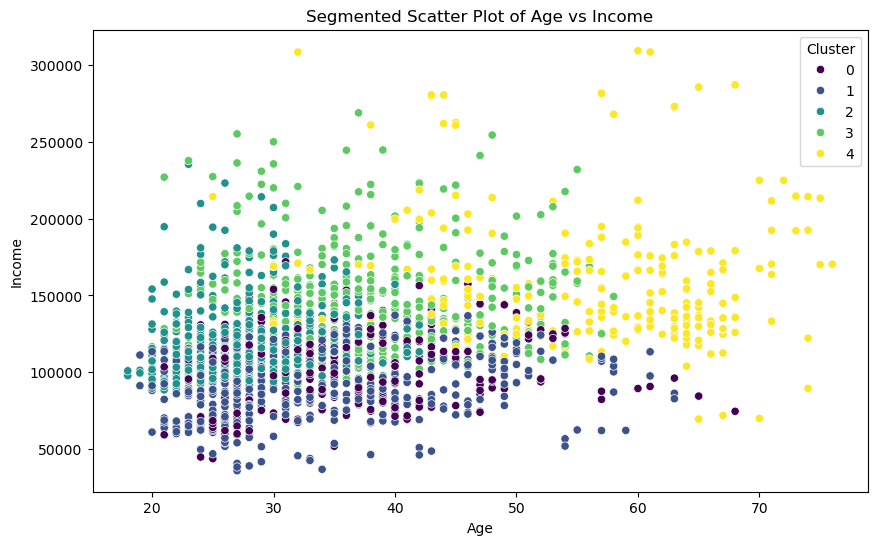

In [19]:
scatter_plot(df_segmented, "Age", "Income", hue="Cluster", title="Segmented Scatter Plot of Age vs Income")

Did a decent job but can be improved by reducing some dimensions

## Dimensionality Curse
### PCA - Principal Component Analysis

In [20]:
data

array([[-0.91739884, -0.99302433,  2.65361447, ...,  0.09752361,
         0.29682303,  1.552326  ],
       [ 1.09003844,  1.00702467, -1.18713209, ...,  0.78265438,
         0.29682303,  1.552326  ],
       [-0.91739884, -0.99302433,  1.11731585, ..., -0.83320224,
        -1.26952539, -0.90972951],
       ...,
       [-0.91739884, -0.99302433, -0.41898277, ..., -0.90695688,
        -1.26952539, -0.90972951],
       [ 1.09003844,  1.00702467, -1.01643224, ..., -0.60332923,
        -1.26952539, -0.90972951],
       [-0.91739884, -0.99302433, -0.93108232, ..., -1.3789866 ,
        -1.26952539, -0.90972951]], shape=(2000, 7))

In [21]:
pca = PCA()
pca.fit(data)


PCA()

PCA components explain the variance of whole data in terms of their importance

In [22]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

In [23]:
print(sum(pca.explained_variance_ratio_))

1.0


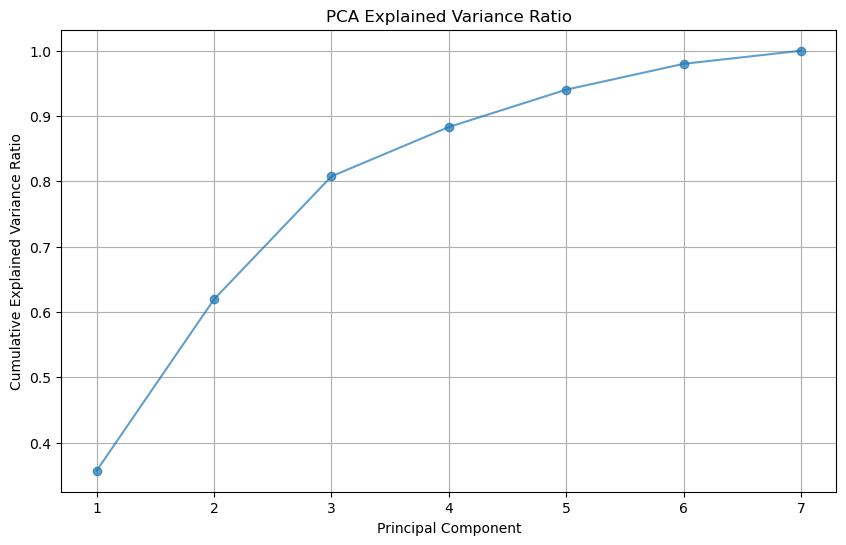

In [24]:
plot_pca_explained_variance(pca, title="PCA Explained Variance Ratio")

**Rule of Thumb** : Keep 80% of the variance
We can go for 3 or 4

In [25]:
for i in [3,4]:
    pca = PCA(n_components=i)
    pca_model = pca.fit(data)


In [26]:
pca_model.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503],
       [-0.31560091,  0.28045392, -0.00950602,  0.18147643, -0.48260023,
        -0.28169039,  0.69026455]])

In [27]:
df_segmented.columns

Index(['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation',
       'Settlement size', 'Cluster'],
      dtype='object')

In [28]:
pca = PCA(n_components=3)
pca_model = pca.fit(data)
df_pca_comp = pd.DataFrame(pca_model.components_,columns = df_segmented.columns.values[:-1],index = [f"PC{i}" for i in range(1,4)])

df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
PC1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
PC2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
PC3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


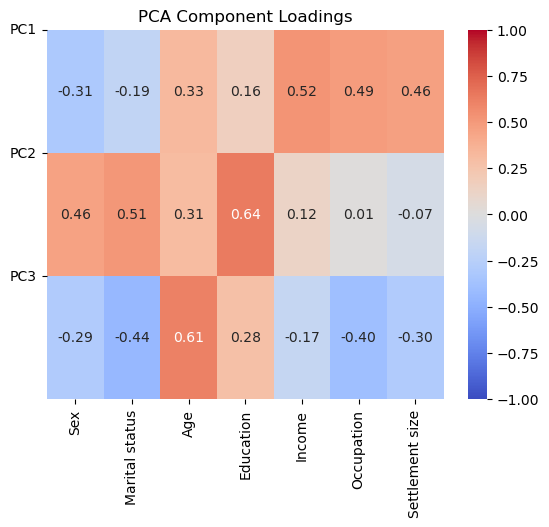

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_pca_comp, vmin=-1,vmax=1,annot=True, cmap='coolwarm', fmt=".2f")
plt.yticks([0,1,2], [f"PC{i}" for i in range(1,4)], rotation=0)
plt.title("PCA Component Loadings")
plt.show()

- PC1 : Income, Occupation,Settlement size, Age
- PC2 : Education,Marital Status,Sex,Age
- PC3 : Age, Marital Status,Occupation

In [30]:
# Based on the loadings in df_pca_comp, we can assign representative names:
# PC1: High positive loadings on Income, Occupation, Settlement size, Age
# PC2: High positive loadings on Education, Marital status, Sex, Age
# PC3: High positive loading on Age, negative on Marital status, Occupation

pca_component_names = {
    "PC1": "Affluence & Career",
    "PC2": "Education & Family Status",
    "PC3": "Age & Independence"
}

pca_component_names

{'PC1': 'Affluence & Career',
 'PC2': 'Education & Family Status',
 'PC3': 'Age & Independence'}

In [31]:
data

array([[-0.91739884, -0.99302433,  2.65361447, ...,  0.09752361,
         0.29682303,  1.552326  ],
       [ 1.09003844,  1.00702467, -1.18713209, ...,  0.78265438,
         0.29682303,  1.552326  ],
       [-0.91739884, -0.99302433,  1.11731585, ..., -0.83320224,
        -1.26952539, -0.90972951],
       ...,
       [-0.91739884, -0.99302433, -0.41898277, ..., -0.90695688,
        -1.26952539, -0.90972951],
       [ 1.09003844,  1.00702467, -1.01643224, ..., -0.60332923,
        -1.26952539, -0.90972951],
       [-0.91739884, -0.99302433, -0.93108232, ..., -1.3789866 ,
        -1.26952539, -0.90972951]], shape=(2000, 7))

In [32]:
scores = pca_model.transform(data)
print(scores)

[[ 2.51474593  0.83412239  2.1748059 ]
 [ 0.34493528  0.59814564 -2.21160279]
 [-0.65106267 -0.68009318  2.2804186 ]
 ...
 [-1.45229829 -2.23593665  0.89657125]
 [-2.24145254  0.62710847 -0.53045631]
 [-1.86688505 -2.45467234  0.66262172]]


## k-Means using PCA

In [33]:
wcss = []
for i in range(1,11,1):
    kmeans_pca = KMeans(n_clusters=i,init="k-means++", random_state=42)
    kmeans_pca.fit(scores)
    wcss.append(kmeans_pca.inertia_)

In [34]:
wcss

[11307.57113594591,
 8023.431965893962,
 6218.24198856893,
 4655.265049937123,
 3864.5495470866204,
 3455.112715639241,
 2949.3814290634123,
 2602.0014245797092,
 2404.908711054778,
 2096.3616858184246]

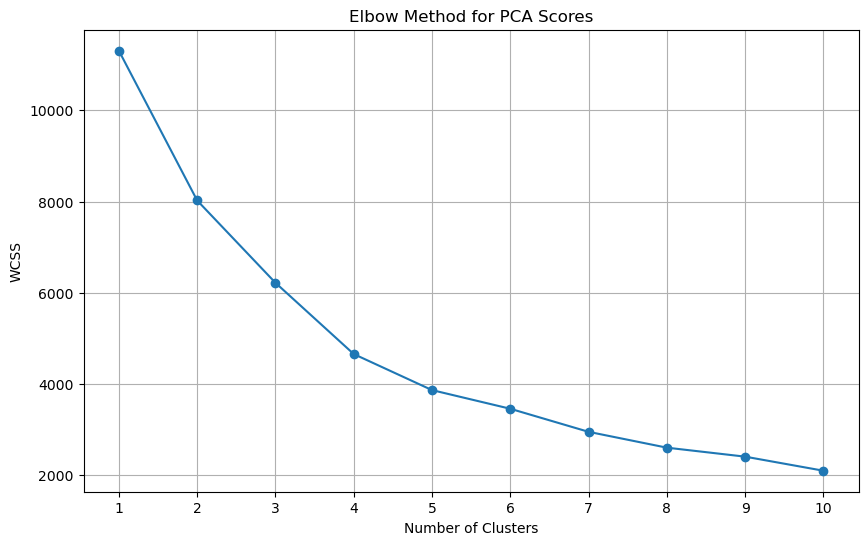

In [35]:
plot_elbow(wcss=wcss, title="Elbow Method for PCA Scores")

number of clusters = 4 
As per the graph of wcss

In [36]:
kmeans_pca = KMeans(n_clusters=4, init="k-means++", random_state=42)
kmeans_pca.fit(scores)

KMeans(n_clusters=4, random_state=42)

In [37]:
scores_df = pd.DataFrame(scores, columns=[f"PC{i}" for i in range(1, 4)],index = df_segmented.index)
scores_df

,PC1,PC2,PC3
ID,,,
100000001,2.514746,0.834122,2.174806
100000002,0.344935,0.598146,-2.211603
100000003,-0.651063,-0.680093,2.280419
100000004,1.714316,-0.579927,0.730731
100000005,1.626745,-0.440496,1.244909
...,...,...,...
100001996,-0.866034,0.298330,1.438958
100001997,-1.114957,0.794727,-1.079871
100001998,-1.452298,-2.235937,0.896571


In [38]:
scores

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]], shape=(2000, 3))

In [39]:
df_segmented_pca = df_segmented.copy()
df_segmented_pca["Cluster_PCA"] = kmeans_pca.labels_
df_segmented_pca = pd.concat([df_segmented_pca, scores_df], axis=1)
df_segmented_pca = df_segmented_pca.reset_index(drop=True)
df_segmented_pca.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster,Cluster_PCA,PC1,PC2,PC3
0,0,0,67,2,124670,1,2,4,3,2.514746,0.834122,2.174806
1,1,1,22,1,150773,1,2,2,2,0.344935,0.598146,-2.211603
2,0,0,49,1,89210,0,0,0,1,-0.651063,-0.680093,2.280419
3,0,0,45,1,171565,1,1,3,0,1.714316,-0.579927,0.730731
4,0,0,53,1,149031,1,1,3,0,1.626745,-0.440496,1.244909


In [40]:
segment_analysis_pca = df_segmented_pca.groupby("Cluster_PCA").mean()
segment_analysis_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster,PC1,PC2,PC3
Cluster_PCA,,,,,,,,,,,
0,0.001661,0.041528,36.674419,0.684385,138482.186047,1.200997,1.255814,2.345515,1.228891,-1.220013,0.041063
1,0.627869,0.454098,33.473770,0.944262,88824.154098,0.078689,0.009836,0.703279,-1.607567,-0.110732,0.625678
2,0.762357,0.973384,27.889734,1.007605,119503.418251,1.055133,0.813688,2.000000,-0.395592,0.518043,-1.204763
3,0.492366,0.683206,55.919847,2.129771,158400.877863,1.125954,1.099237,3.839695,1.713376,2.021006,0.867641


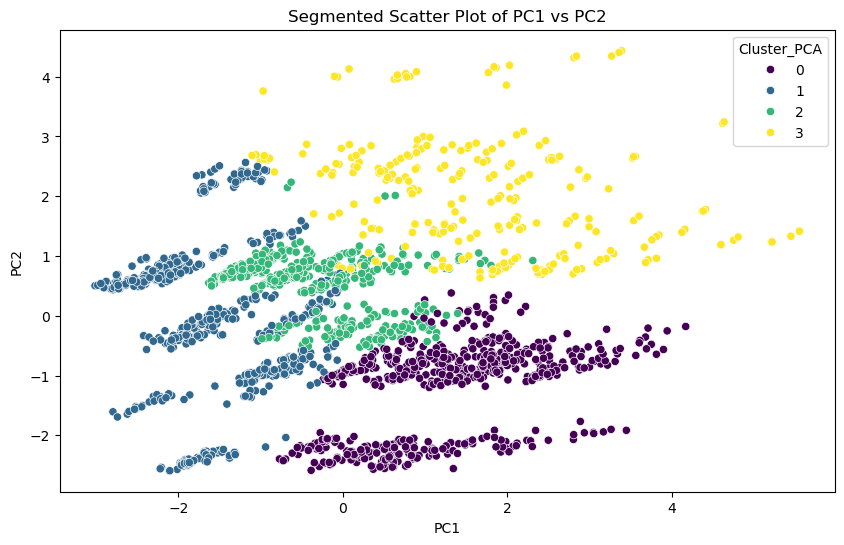

In [41]:
scatter_plot(df_segmented_pca, "PC1", "PC2", hue="Cluster_PCA", title="Segmented Scatter Plot of PC1 vs PC2")

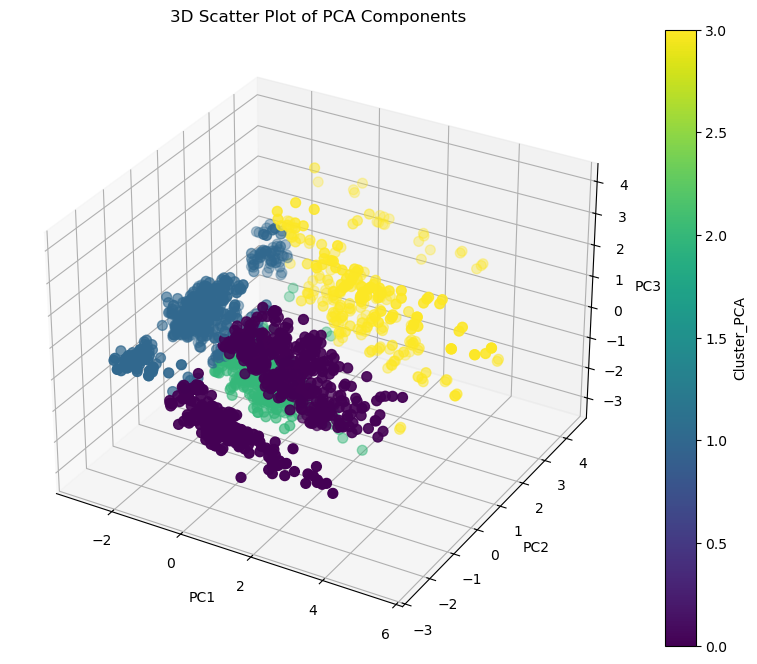

In [42]:

plot_3d_scatter(df_segmented_pca, x_col="PC1", y_col="PC2", z_col="PC3", hue_col="Cluster_PCA", title="3D Scatter Plot of PCA Components")

In [43]:
df_segmented_pca = df_segmented_pca.rename(columns = pca_component_names,inplace = True)

## Export the data

In [ ]:
export_to_pickle(scaler,"scaler")
#export_to_pickle(pca_component_names,"")
export_to_pickle(pca_model,"pca")
export_to_pickle(kmeans_pca,"Kmeans_pca")

object saved at :  c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\Notebooks\..\Data\artifacts\scaler.pickle
object saved at :  c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\Notebooks\..\Data\artifacts\pca.pickle
object saved at :  c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\Notebooks\..\Data\artifacts\Kmeans_pca.pickle
